Should I go to ACC/CCA for a year and transfer to SDSU if I want to minimize my student loans in the next 4 years in a career of health/physiology/pharmacology

X = Total amount of student loan debt after graduation (measured in $)
- The outcome of interest is the expected total student loan debt (E[X]) under each option.
The option with the lower average or median X indicates the path that is most likely to minimize student loans over the next 5 years.


--- Simulation Summary ---
                  Path  Mean Balance ($)  Median Balance ($)  \
0  ACC→SDSU (transfer)           $78,068             $77,930   
1          SDSU direct           $82,972             $82,892   

   10th Percentile ($)  90th Percentile ($)  
0              $67,218              $89,081  
1              $71,691              $94,636  


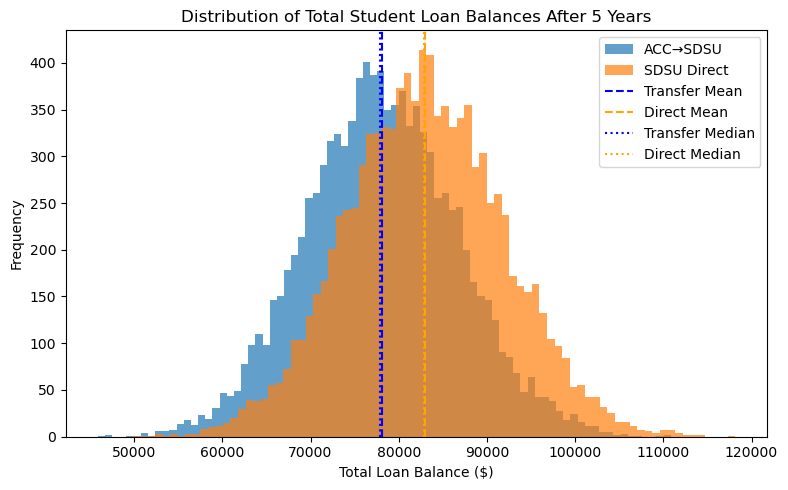

In [12]:
# -----------------------------
# Simulation: Minimizing Student Loans
# Comparing ACC/CCA → SDSU vs. SDSU Direct
# -----------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Simulation function definitions ---

def simulate_one_path(path, params):
    """
    Simulates one trial of total student loan balance after 5 years.
    path: 'transfer' (ACC/CCA -> SDSU) or 'direct' (SDSU all 4 years)
    params: dictionary of simulation parameters
    """
    # Which institution each year (4 years total)
    if path == 'transfer':
        years_institutions = ['ACC'] + ['SDSU']*3
    else:
        years_institutions = ['SDSU']*4

    # Random annual interest rate (between min and max)
    r = np.random.uniform(params['r_min'], params['r_max'])

    loan_chunks = []  # (amount_borrowed, years_until_5)

    for year_idx, inst in enumerate(years_institutions):
        # Sample tuition and aid values
        if inst == 'ACC':
            tuition = np.random.normal(params['acc_tuition_mean'], params['acc_tuition_sd'])
            grant = np.random.normal(params['acc_grant_mean'], params['acc_grant_sd'])
        else:
            tuition = np.random.normal(params['sdsu_tuition_mean'], params['sdsu_tuition_sd'])
            grant = np.random.normal(params['sdsu_grant_mean'], params['sdsu_grant_sd'])

        # Living and fees (similar for both)
        living = np.random.normal(params['living_mean'], params['living_sd'])
        fees = np.random.normal(params['fees_mean'], params['fees_sd'])
        part_time = np.random.normal(params['part_time_mean'], params['part_time_sd'])

        # Compute cost for the year
        total_cost = max(0, tuition + living + fees - grant - part_time)
        borrowed = total_cost

        # How many years interest accrues until year 5
        years_until_5 = 5 - year_idx
        loan_chunks.append((borrowed, years_until_5))

    # Accrue interest on each year's borrowing
    balance = 0
    for amt, yrs in loan_chunks:
        balance += amt * ((1 + r) ** yrs)

    return balance


def run_simulation(N=10000):
    """
    Run N trials for both paths and return a DataFrame of results.
    """
    params = {
        'acc_tuition_mean': 4200, 'acc_tuition_sd': 700,
        'sdsu_tuition_mean': 9000, 'sdsu_tuition_sd': 1500,
        'acc_grant_mean': 1200, 'acc_grant_sd': 800,
        'sdsu_grant_mean': 2000, 'sdsu_grant_sd': 1500,
        'living_mean': 12000, 'living_sd': 2500,
        'fees_mean': 1500, 'fees_sd': 300,
        'part_time_mean': 3000, 'part_time_sd': 1500,
        'r_min': 0.035, 'r_max': 0.065
    }

    results = []
    for _ in range(N):
        bal_transfer = simulate_one_path('transfer', params)
        bal_direct = simulate_one_path('direct', params)
        results.append({'balance_transfer': bal_transfer, 'balance_direct': bal_direct})

    df = pd.DataFrame(results)
    return df

# --- Run the simulation ---
N = 10000
df = run_simulation(N)

# --- Summary statistics ---
summary = pd.DataFrame({
    'Path': ['ACC→SDSU (transfer)', 'SDSU direct'],
    'Mean Balance ($)': [df['balance_transfer'].mean(), df['balance_direct'].mean()],
    'Median Balance ($)': [df['balance_transfer'].median(), df['balance_direct'].median()],
    '10th Percentile ($)': [df['balance_transfer'].quantile(0.10), df['balance_direct'].quantile(0.10)],
    '90th Percentile ($)': [df['balance_transfer'].quantile(0.90), df['balance_direct'].quantile(0.90)]
})

print("\n--- Simulation Summary ---")
print(summary.round(2))

# --- Visualization: histograms with mean & median lines ---

plt.figure(figsize=(8, 5))
plt.hist(df['balance_transfer'], bins=80, alpha=0.7, label='ACC→SDSU')
plt.hist(df['balance_direct'], bins=80, alpha=0.7, label='SDSU Direct')
plt.axvline(df['balance_transfer'].mean(), color='blue', linestyle='--', label='Transfer Mean')
plt.axvline(df['balance_direct'].mean(), color='orange', linestyle='--', label='Direct Mean')
plt.axvline(df['balance_transfer'].median(), color='blue', linestyle=':', label='Transfer Median')
plt.axvline(df['balance_direct'].median(), color='orange', linestyle=':', label='Direct Median')
plt.title("Distribution of Total Student Loan Balances After 5 Years")
plt.xlabel("Total Loan Balance ($)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()



=== Measures of Central Tendency & Spread ===
                        Path  Mean Debt  Median Debt  10th Percentile  \
0  Transfer (CCA→CU Boulder)    $17,757      $17,634           $9,396   
1     Direct (SoCal Average)    $15,561      $15,584           $9,528   

   90th Percentile  
0          $26,204  
1          $21,510  

Empirical  P(transfer debt < direct debt): 0.393
Theoretical P(transfer debt < direct debt): 0.392
Mean difference (Direct − Transfer): $-2,195
Median difference (Direct − Transfer): $-2,049


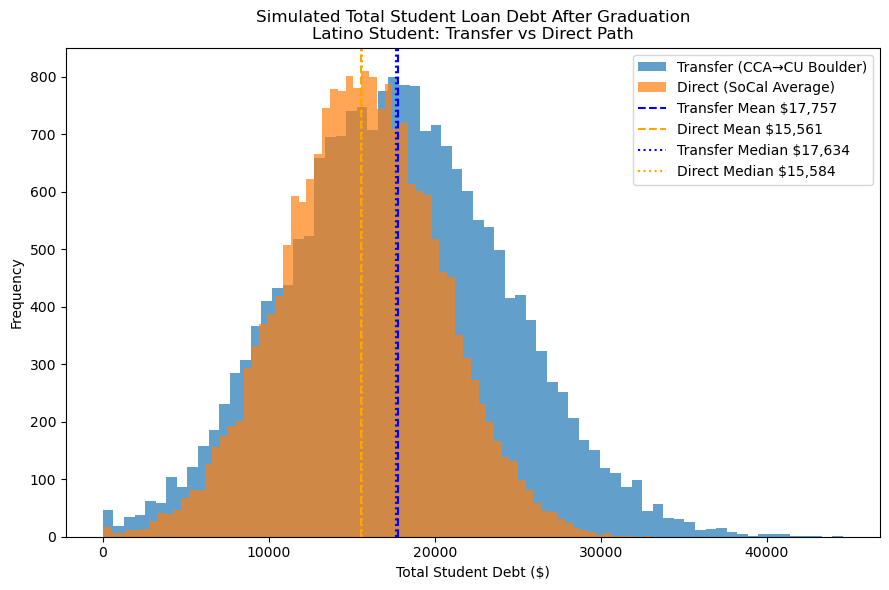

In [11]:
# ---------------------------------------------
# Simulation: Transfer (CCA->CU Boulder) vs Direct (SoCal Average)
# Latino undergraduate, minimizing debt
# ---------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(42)

# ----- Known medians -----
median_socal = np.mean([15000, 15500, 16666, 15000])  # 4 SoCal schools
median_cu_boulder = 19500
median_cca = 10500

# ----- Assumptions -----
ASSUME = {
    "cca_1yr_fraction": 0.25,          # one-year at CCA (¼ of full program median)
    "cca_sd_fraction": 0.35,           # variability of CCA debt
    "cu_sd_fraction": 0.30,            # variability of CU Boulder debt
    "socal_sd_fraction": 0.30,         # variability of SoCal debt
    "n_trials": 20000
}

# ----- Functions -----
def sample_transfer_debt():
    """Sample total debt for 1 yr CCA + 3 yrs CU Boulder."""
    cca_sample = np.random.normal(median_cca * ASSUME["cca_1yr_fraction"],
                                  median_cca * ASSUME["cca_sd_fraction"])
    cu_sample = np.random.normal(median_cu_boulder * (3/4),
                                 median_cu_boulder * ASSUME["cu_sd_fraction"])
    return max(0, cca_sample) + max(0, cu_sample)

def sample_direct_debt():
    """Sample total debt for 4-yr SoCal university."""
    return max(0, np.random.normal(median_socal, median_socal * ASSUME["socal_sd_fraction"]))

# ----- Monte Carlo -----
N = ASSUME["n_trials"]
transfer = np.array([sample_transfer_debt() for _ in range(N)])
direct = np.array([sample_direct_debt() for _ in range(N)])

# ----- Empirical and theoretical probabilities -----
empirical_p = np.mean(transfer < direct)

mu_diff = transfer.mean() - direct.mean()
sigma_diff = np.sqrt(transfer.var(ddof=1) + direct.var(ddof=1))
theoretical_p = norm.cdf(0, loc=mu_diff, scale=sigma_diff)

# ----- Summary statistics -----
summary = pd.DataFrame({
    "Path": ["Transfer (CCA→CU Boulder)", "Direct (SoCal Average)"],
    "Mean Debt": [transfer.mean(), direct.mean()],
    "Median Debt": [np.median(transfer), np.median(direct)],
    "10th Percentile": [np.percentile(transfer, 10), np.percentile(direct, 10)],
    "90th Percentile": [np.percentile(transfer, 90), np.percentile(direct, 90)]
})

print("\n=== Measures of Central Tendency & Spread ===")
print(summary.round(2))
print("\nEmpirical  P(transfer debt < direct debt): {:.3f}".format(empirical_p))
print("Theoretical P(transfer debt < direct debt): {:.3f}".format(theoretical_p))
print("Mean difference (Direct − Transfer): ${:,.0f}".format(direct.mean() - transfer.mean()))
print("Median difference (Direct − Transfer): ${:,.0f}".format(np.median(direct) - np.median(transfer)))

# ----- Visualization -----
plt.figure(figsize=(9,6))
plt.hist(transfer, bins=70, alpha=0.7, label="Transfer (CCA→CU Boulder)")
plt.hist(direct, bins=70, alpha=0.7, label="Direct (SoCal Average)")
plt.axvline(transfer.mean(), color='blue', linestyle='--', label=f"Transfer Mean ${transfer.mean():,.0f}")
plt.axvline(direct.mean(), color='orange', linestyle='--', label=f"Direct Mean ${direct.mean():,.0f}")
plt.axvline(np.median(transfer), color='blue', linestyle=':', label=f"Transfer Median ${np.median(transfer):,.0f}")
plt.axvline(np.median(direct), color='orange', linestyle=':', label=f"Direct Median ${np.median(direct):,.0f}")
plt.title("Simulated Total Student Loan Debt After Graduation\nLatino Student: Transfer vs Direct Path")
plt.xlabel("Total Student Debt ($)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


  Transfer (CCA→CU Boulder)    $17,757     (Mean Debt) 
1     Direct (SoCal Average)    $15,561    (Mean Debt)
This means that the mean debt is lower from a direct SoCal average than transfering from CCA to boulder. ($ 15,561 vs $ 17,757)



Empirical  P(transfer debt < direct debt): 0.393
Theoretical P(transfer debt < direct debt): 0.392